In [7]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import os

path = os.getcwd()
path_betas = "GIMME analyses/Cleaned GIMME Data/Control_Group_output/individual/10"
path_data = "GIMME analyses/Cleaned GIMME Data/Control_Group/10"

In [3]:
def get_cov(VR, SS, ANX, INT, alpha, cov_type):
    "Return the 4x4 covariance structure specified by cov_type. cov_type can be 'diagonal', 'AR1' or 'compound'."
    
    var_vr = np.nanvar(VR)  
    var_ss = np.nanvar(SS)
    var_anx = np.nanvar(ANX)
    var_int = np.nanvar(INT)
    std_vr, std_ss, std_anx, std_int = np.sqrt(var_vr), np.sqrt(var_ss), np.sqrt(var_anx), np.sqrt(var_int)
    
    #diagonal
    #this should correspond to using alpha*np.random.randn(4)*np.array([std_vr, ..., std_int]) for noise
    diagonal = alpha**2*np.diag([var_vr, var_ss, var_anx, var_int])
    
    #AR1
    AR1_cov = np.zeros((4,4))
    AR1_cov[0, 0], AR1_cov[1, 1], AR1_cov[2, 2], AR1_cov[3, 3] = var_vr, var_ss, var_anx, var_int #diagonal 0
    AR1_cov[0, 1], AR1_cov[1, 2], AR1_cov[2, 3] = alpha*np.array([std_vr*std_ss, std_ss*std_anx, std_anx*std_int]) #diagonal 1
    AR1_cov[1, 0], AR1_cov[2, 1], AR1_cov[3, 2] = AR1_cov[0, 1], AR1_cov[1, 2], AR1_cov[2, 3]
    AR1_cov[0, 2], AR1_cov[1, 3] = alpha**2*np.array([std_vr*std_anx, std_ss*std_int]) #diagonal 2
    AR1_cov[2, 0], AR1_cov[3, 1] = AR1_cov[0, 2], AR1_cov[1, 3]
    AR1_cov[0, 3] = AR1_cov[3, 0] = alpha**3*(std_vr*std_int) #diagonal 3
    
    #compound 
    cov = np.zeros((4,4))
    cov[0, 0], cov[1, 1], cov[2, 2], cov[3, 3] = var_vr, var_ss, var_anx, var_int #diagonal 0
    cov[0, 1], cov[1, 2], cov[2, 3] = alpha*np.array([std_vr*std_ss, std_ss*std_anx, std_anx*std_int]) #diagonal 1
    cov[1, 0], cov[2, 1], cov[3, 2] = cov[0, 1], cov[1, 2], cov[2, 3]
    cov[0, 2], cov[1, 3] = alpha*np.array([std_vr*std_anx, std_ss*std_int]) #diagonal 2
    cov[2, 0], cov[3, 1] = cov[0, 2], cov[1, 3]
    cov[0, 3] = cov[3, 0] = alpha*(std_vr*std_int) #diagonal 3
    
    if cov_type == 'simple': 
        return simple_error
    elif cov_type == 'AR1':
        return AR1_cov 
    else: 
        return cov

In [9]:
def get_matrix_multivariate(ind, shape, contemp_coeff, lagged_coeff, alpha, cov_type):
    "Return simulated data of VR, SS, ANX and INT in matrix of shape shape for individual ind with covariance structure\
     given by cov_type. Shape = (# of days, # of variables)."
    
    path_data = "GIMME analyses/Cleaned GIMME Data/Control_Group/10" 
    VR, SS, ANX, INT = np.genfromtxt(path_data+ind+'.txt', skip_header=1, unpack=True)
    var_vr, mean_vr = np.nanvar(VR), np.nanmean(VR)  
    var_ss, mean_ss = np.nanvar(SS), np.nanmean(SS)
    var_anx, mean_anx = np.nanvar(ANX), np.nanmean(ANX)
    var_int, mean_int = np.nanvar(INT), np.nanmean(INT)
    
    M = np.zeros(shape)
    covariance = get_cov(VR, SS, ANX, INT, alpha, cov_type)
    noise = np.random.multivariate_normal(np.zeros(4), covariance)
    M[0,:] = np.array([mean_vr, mean_ss, mean_anx, mean_int]) + noise

    #M[r] = (I-A)^-1 * B * M[r-1] + noise + mean 
    for r in range(1, shape[0]): 
        noise = np.random.multivariate_normal(np.zeros(4), covariance)
        M[r] = np.matmul(np.matmul(np.linalg.inv(np.eye(4)-contemp_coeff),lagged_coeff),M[r-1])     
        M[r] += noise
    M[:,:] += np.array([mean_vr, mean_ss, mean_anx, mean_int])
    
    #clipping VR (0-5)
    indices = np.where(M[:,0]<0)[0]
    M[indices,0] = 0
    indices = np.where(M[:,0]>5)[0]
    M[indices,0] = 5

    #clipping other variables (1-5)
    indices = np.where(M[:,1:4]<1)[0]
    M[indices,1:4] = 1
    indices = np.where(M[:,1:4]>5)[0]
    M[indices,1:4] = 5

    return M

In [10]:
#AR1

numbers = ['01','02','03','04','05','06','07','08','09','10','11','12','13']

for alpha in [0.01, 0.1, 0.5]:
    for rep in range(1,11):  
        for num in numbers:
            data = np.loadtxt(path_betas+num+'Betas.csv', skiprows=1, usecols=range(1,9), delimiter=',')
            A = data[:,4:] 
            B = data[:,:4] 
            
            M = get_matrix_multivariate(num, (75,4), A, B, alpha, 'AR1')

            np.savetxt(path+'/AR1_Heterogenous/AR1_'+str(alpha)+'/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                       M, delimiter=',', header='VR,SS,ANX,INT', comments='')

In [20]:
#Compound 

for alpha in [0.01, 0.1, 0.5]:
    for rep in range(1,11):  
        for num in numbers:
            data = np.loadtxt(path_betas+num+'Betas.csv', skiprows=1, usecols=range(1,9), delimiter=',')
            A = data[:,4:] 
            B = data[:,:4] 
            
            M = get_matrix_multivariate(num, (75,4), A, B, alpha, 'compound')

            np.savetxt(path+'/Compound_Heterogenous/Compound_'+str(alpha)+'/rep_'+str(rep)+'/ind_'+str(int(num))+'.txt', 
                       M, delimiter=',', header='VR,SS,ANX,INT', comments='')

# Plots

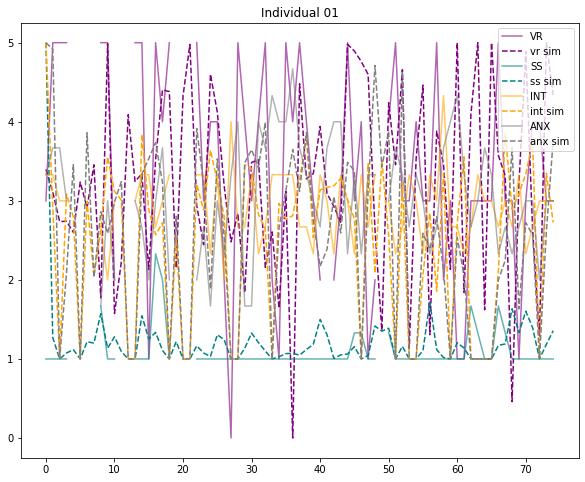

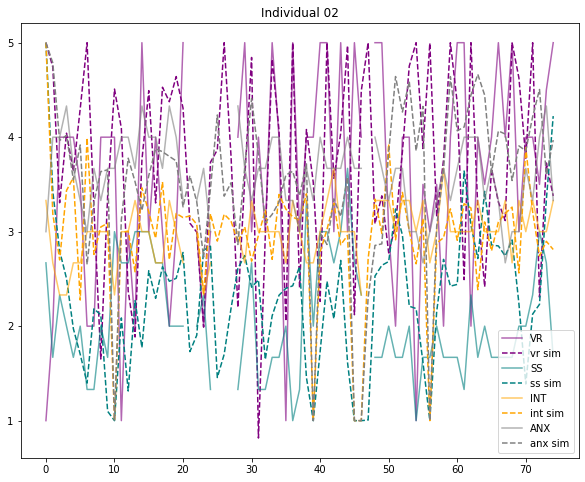

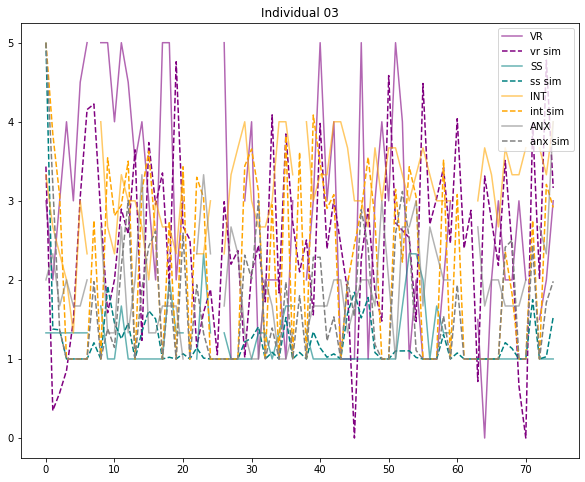

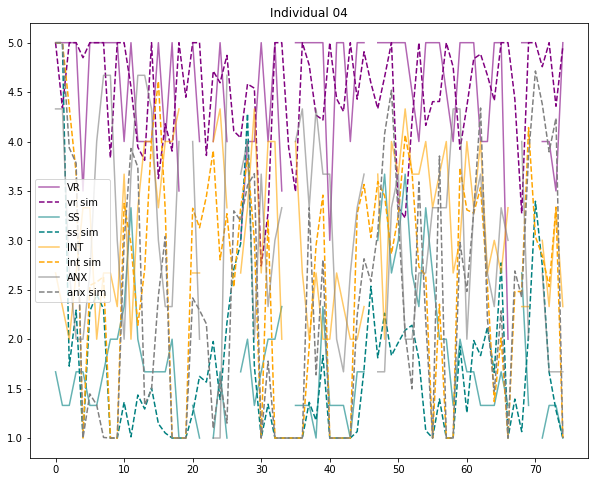

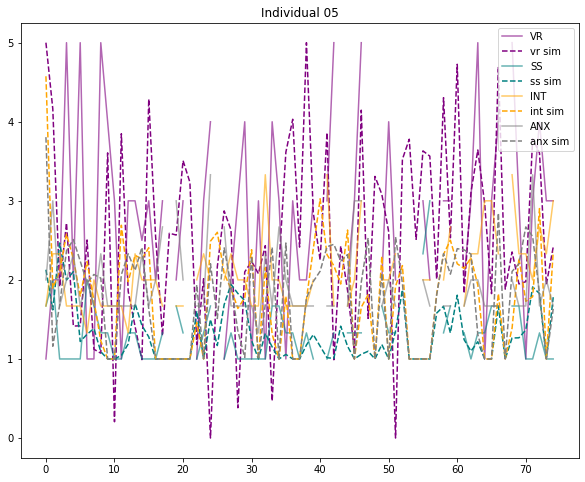

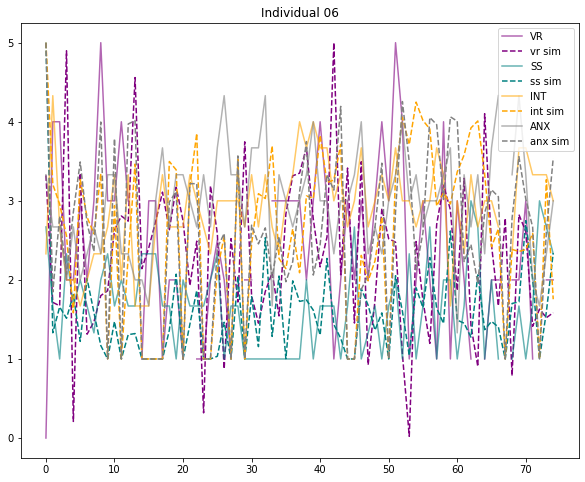

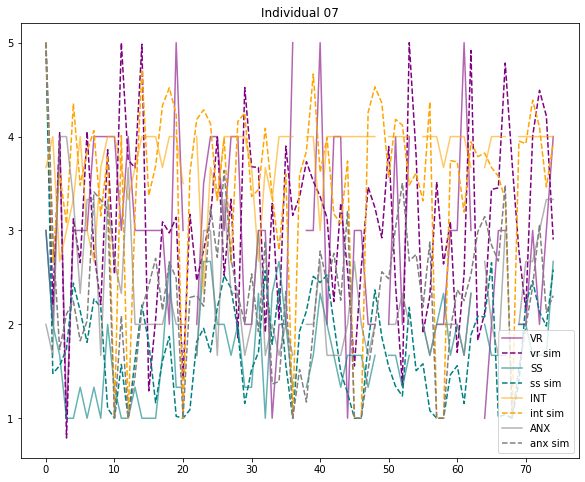

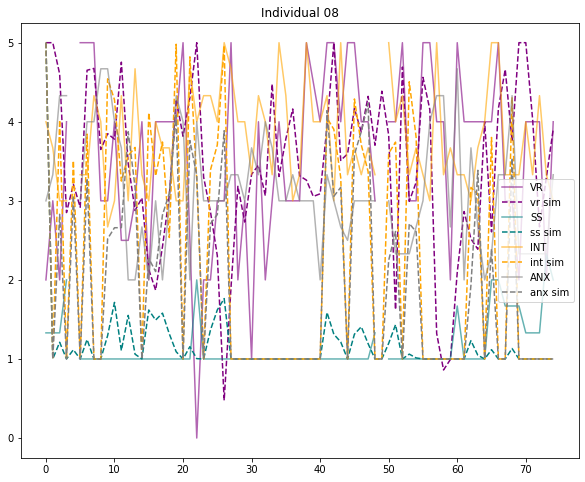

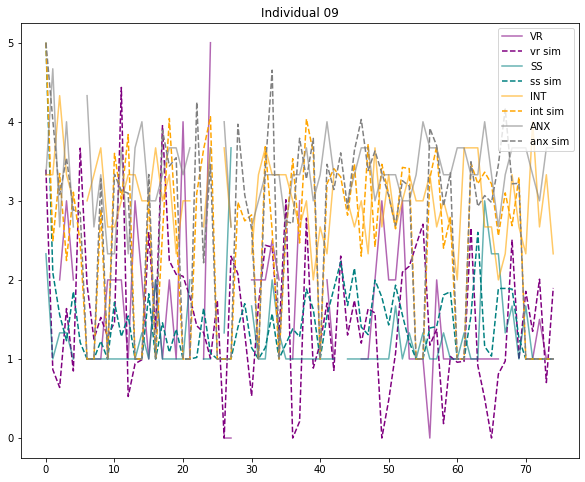

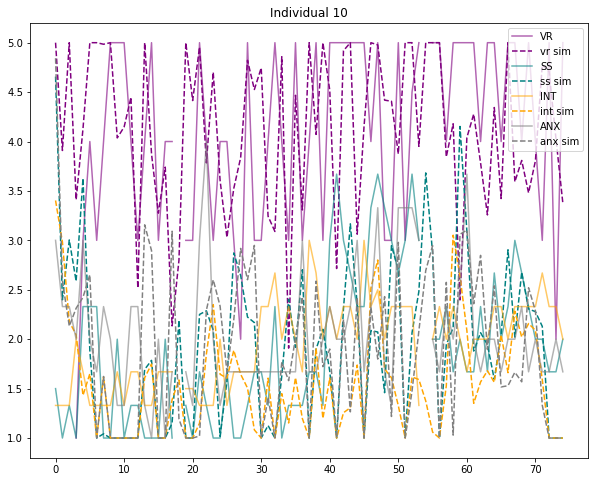

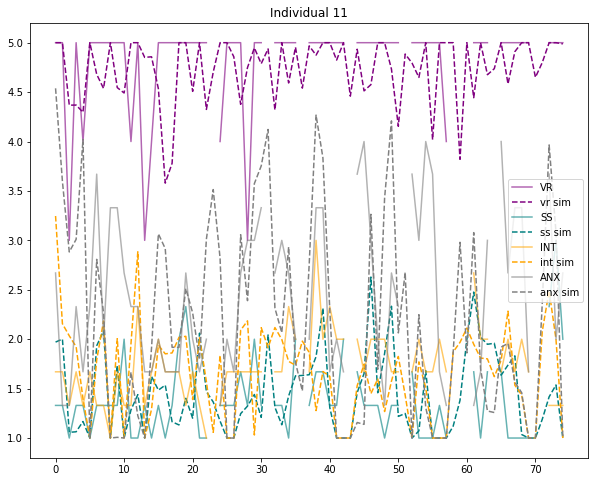

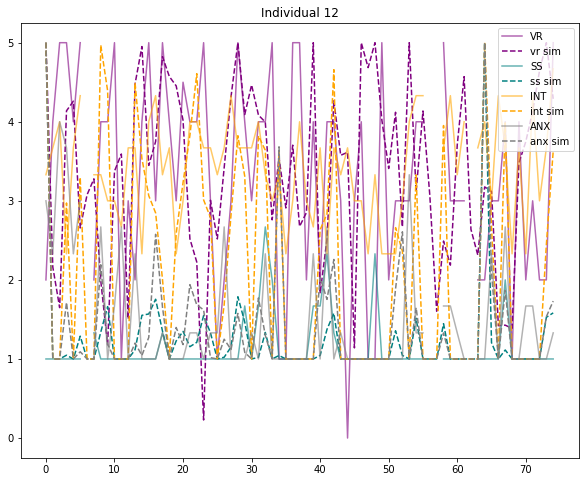

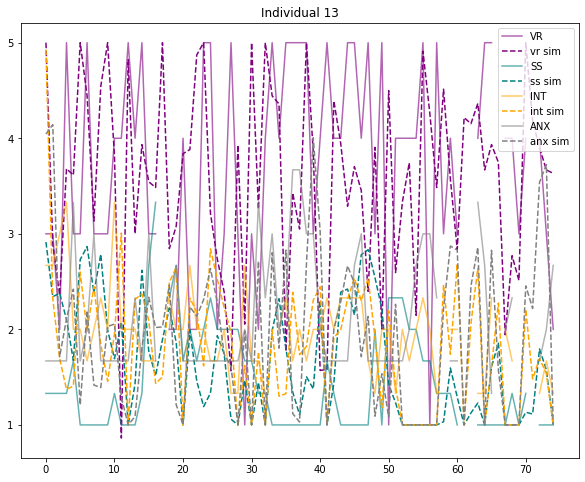

In [19]:
#Plot emperical data and sim with AR1 structure

alpha = [0.01, 0.1, 0.5]
i = 0 
t = np.arange(0, 75)

for num in numbers:
    plt.figure(figsize=(10,8))
    VR, SS, ANX, INT = np.genfromtxt(path_data+num+'.txt', skip_header=1, unpack=True)
    vr, ss, anx, intt = np.loadtxt(path+'/AR1_Heterogenous/AR1_'+str(alpha[i])+'/rep_1/ind_'+str(int(num))+'.txt',
                                  skiprows=1, delimiter=',', unpack=True)
    
    plt.plot(t, VR, label='VR', linestyle='-', alpha=0.6, color='purple')
    plt.plot(t, vr, label='vr sim', linestyle='--', color='purple')

    plt.plot(t, SS, label='SS', linestyle='-', alpha=0.6, color='teal')
    plt.plot(t, ss, label='ss sim', linestyle='--', color='teal')

    plt.plot(t, INT, label='INT', linestyle='-', alpha=0.6, color='orange')
    plt.plot(t, intt, label='int sim', linestyle='--', color='orange')

    plt.plot(t, ANX, label='ANX', linestyle='-', alpha=0.6, color='gray')
    plt.plot(t, anx, label='anx sim', linestyle='--', color='gray')
    
    plt.title('Individual '+num)
    plt.legend()


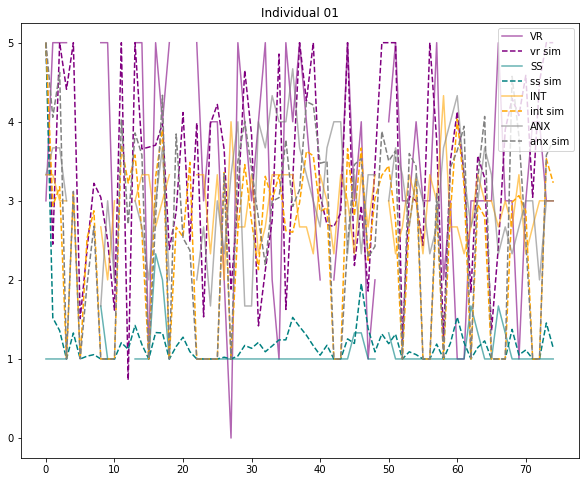

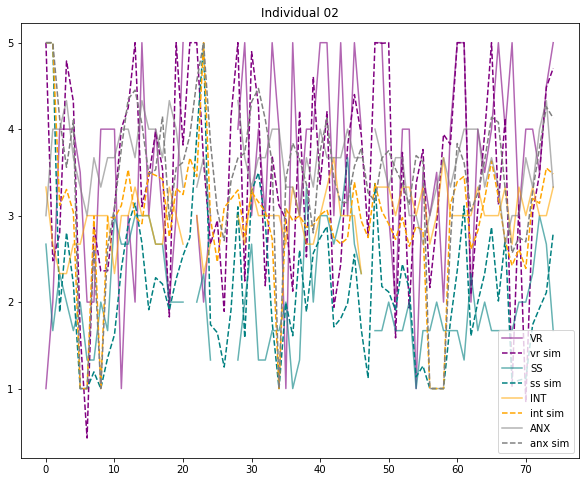

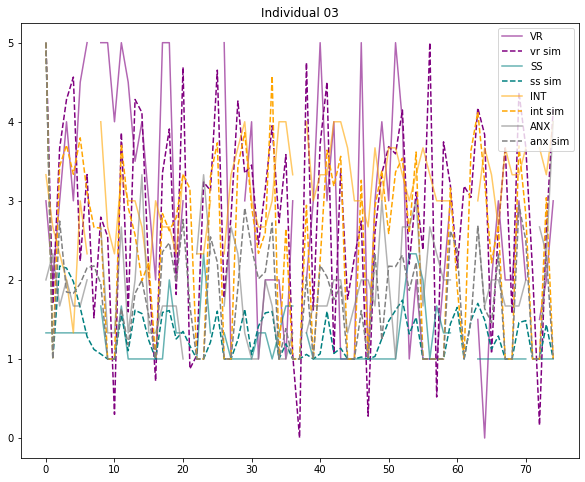

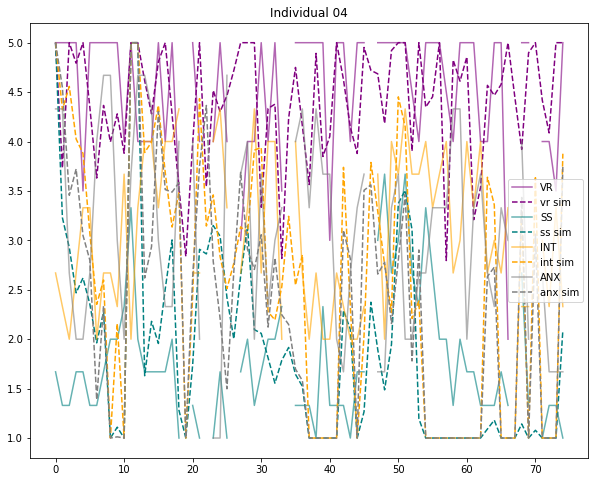

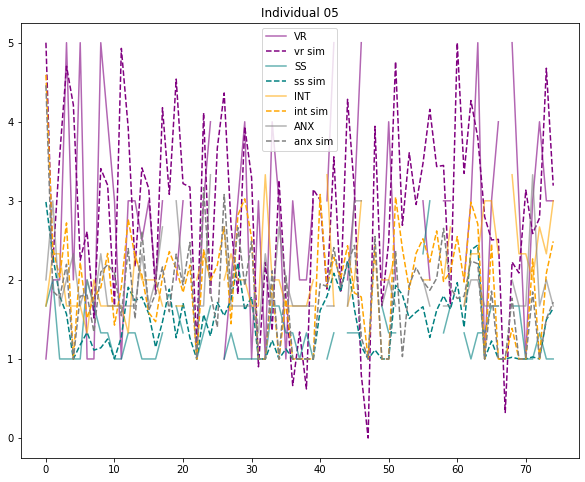

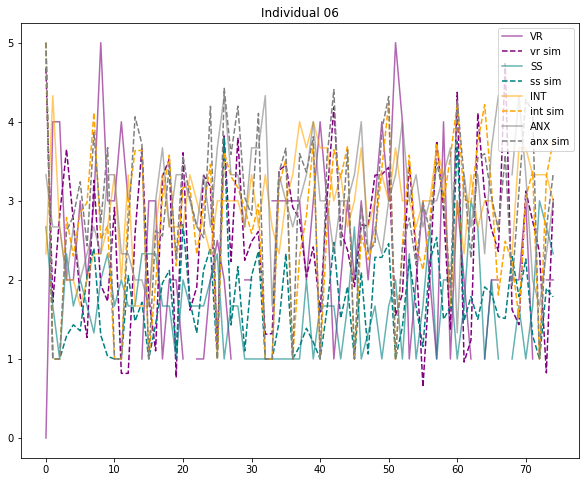

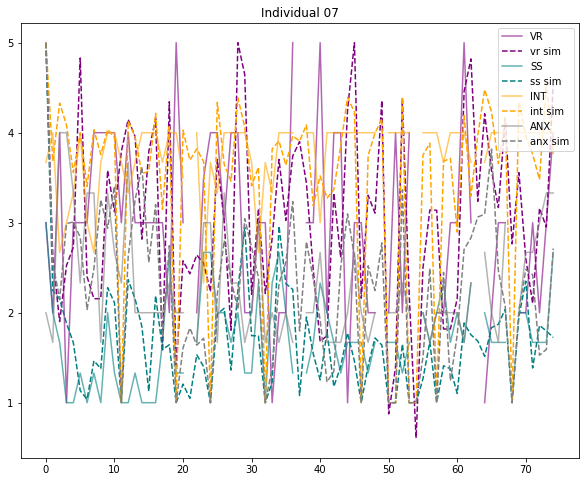

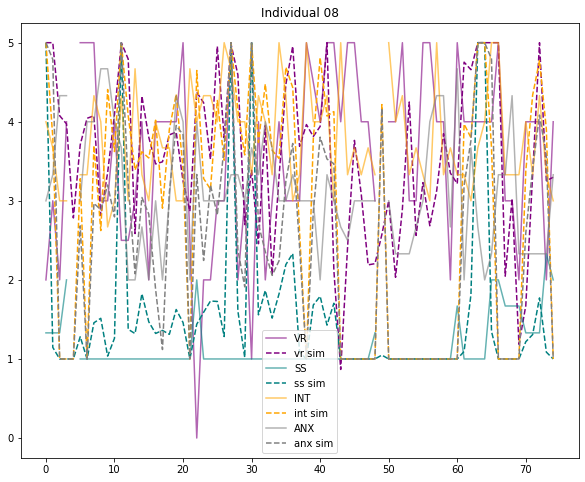

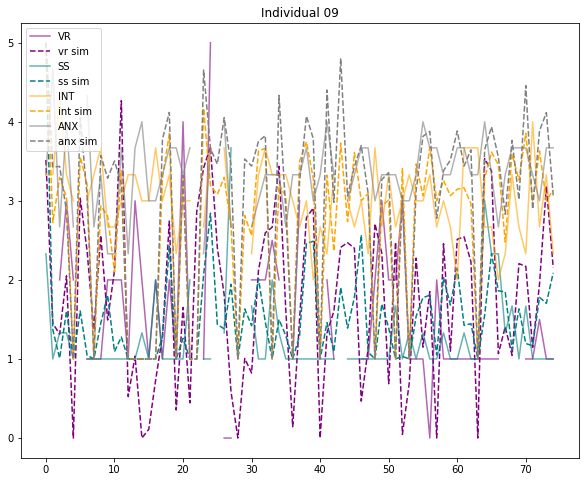

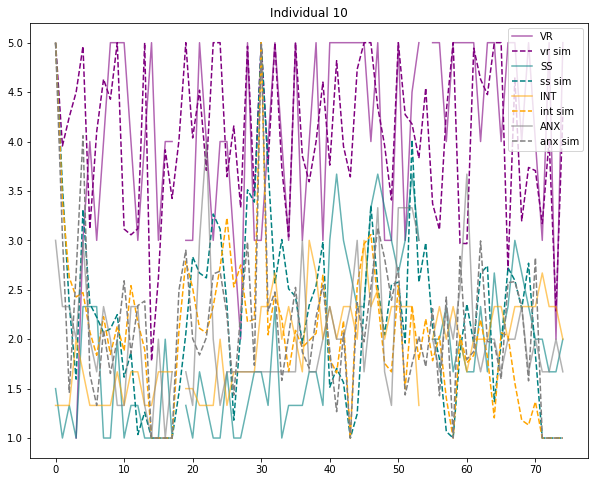

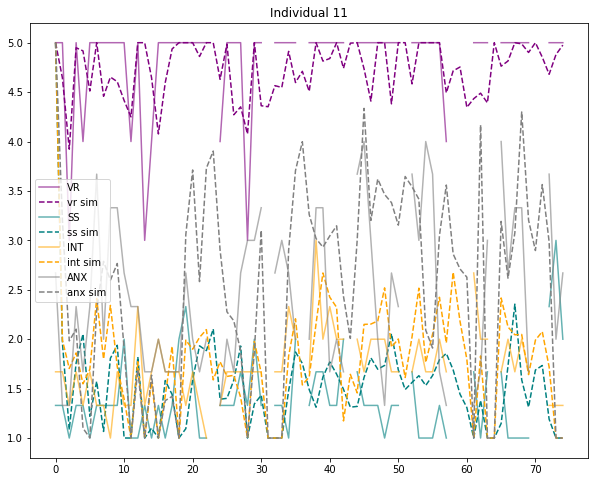

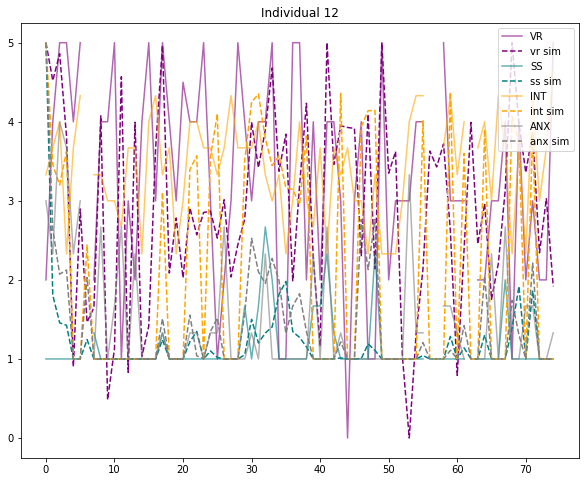

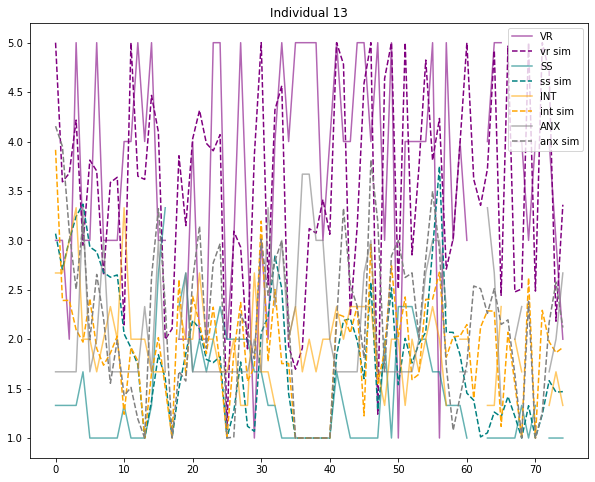

In [22]:
#Plot emperical data and sim with compound structure

alpha = [0.01, 0.1, 0.5]
i = 2
t = np.arange(0, 75)

for num in numbers:
    plt.figure(figsize=(10,8))
    VR, SS, ANX, INT = np.genfromtxt(path_data+num+'.txt', skip_header=1, unpack=True)
    vr, ss, anx, intt = np.loadtxt(path+'/Compound_Heterogenous/Compound_'+str(alpha[i])+'/rep_1/ind_'+str(int(num))+'.txt',
                                  skiprows=1, delimiter=',', unpack=True)
    
    plt.plot(t, VR, label='VR', linestyle='-', alpha=0.6, color='purple')
    plt.plot(t, vr, label='vr sim', linestyle='--', color='purple')

    plt.plot(t, SS, label='SS', linestyle='-', alpha=0.6, color='teal')
    plt.plot(t, ss, label='ss sim', linestyle='--', color='teal')

    plt.plot(t, INT, label='INT', linestyle='-', alpha=0.6, color='orange')
    plt.plot(t, intt, label='int sim', linestyle='--', color='orange')

    plt.plot(t, ANX, label='ANX', linestyle='-', alpha=0.6, color='gray')
    plt.plot(t, anx, label='anx sim', linestyle='--', color='gray')
    
    plt.title('Individual '+num)
    plt.legend()